# Preproccessing Data

### Import Dataset

dalam tahapan ini akan dilakukan importing library dan dataset dan mengecek isi dari dataset

In [197]:
import matplotlib.pyplot as plt 
import numpy as np
from nltk.tokenize import word_tokenize
import re
import pandas as pd
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud, STOPWORDS

In [198]:
# pengambilan dataset
df = pd.read_csv("reviews.csv") 

# menampilkan isi dataset
df.head(5)

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


In [199]:
# untuk menghitung banyaknya komentar dengan rating tertentu
df.Rating.value_counts()

Rating
5    22095
1    17653
4     7842
2     7118
3     6886
Name: count, dtype: int64

### Feature Selection

dalam tahapan ini kita akan menyeleksi fitur apa saja yang ingin digunakan. Dalam kasus ini text mining hanya membutuhkan review sebagai fitur untuk x dan rating untuk y (label)

In [200]:
# menghilangkan kolom yang tidak diperlukan
df.drop(columns=["Time_submitted", "Total_thumbsup", "Reply"], inplace=True)

df.head()

,Review,Rating
0,"Great music service, the audio is high quality...",5
1,Please ignore previous negative rating. This a...,5
2,"This pop-up ""Get the best Spotify experience o...",4
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't ...,1


lalu untuk memperjelas label positif dan negatif maka kita hanya menggunakan rating 1 dan 5 saja

In [201]:
# hanya menggunakan rating = 1 dan rating = 5
df = df[(df.Rating == 1) | (df.Rating == 5)]

df.head()

,Review,Rating
0,"Great music service, the audio is high quality...",5
1,Please ignore previous negative rating. This a...,5
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't ...,1
6,I love the selection and the lyrics are provid...,5


setelah itu kita labeli apakah positif atau negatif. 

untuk rating 5 kita labeli 1 yang artinya positif dan untuk rating 1 kita labeli 0 yang artinya negatif

In [202]:
# melabeli 5 dengan 1 (positif) dan melabeli 1 dengan 0 (negatif)
labels = [0 if rate == 1 else 1 for rate in df.Rating]

# menambahkan kolom label
df["Labels"] = labels

df.head()

,Review,Rating,Labels
0,"Great music service, the audio is high quality...",5,1
1,Please ignore previous negative rating. This a...,5,1
3,Really buggy and terrible to use as of recently,1,0
4,Dear Spotify why do I get songs that I didn't ...,1,0
6,I love the selection and the lyrics are provid...,5,1


Agar proses modeling dan pembobotan kata jauh lebih ringan, kita perlu mengambil 3000 data untuk yang label positif dan negatif. Saya mengambil 3000 data dari masing masing class / label karena 3000 tidak terlalu kecil (dibanding dg kolom) dan tak terlalu besar pula

In [203]:
# mengambil data sebanyak 3000 dari tweet positif, 3000 dari tweet negatif
df = pd.concat([df[df.Labels == 0].iloc[:3000], df[df.Labels == 1].iloc[:3000]]).sample(frac=1, random_state=42).reset_index(drop=True)

df

,Review,Rating,Labels
0,Had a 160 hour playlist before I got a free tr...,1,0
1,Update:- Thank You Spotify For Resolving below...,5,1
2,Worst song app because it's have an add in bet...,1,0
3,Enjoy the next 30 minutes free from advertisin...,1,0
4,Thanks for bring all good music together,5,1
...,...,...,...
5995,Look they asked nicely and I decided to rate i...,5,1
5996,I love how this works. It's smooth and I know ...,5,1
5997,Very nice app to lessen songs on own choice 👍,5,1
5998,Great app for listening to UT favorite music,5,1


### Duplicated Data

dalam proses ini kita akan mencari apakah ada data yang terduplikasi atau tidak. Karena data yang terduplikasi ini akan mengganggu proses modeling menjadi berisiko overfitting

In [204]:
# menampilkan data yang terduplikasi
df[df.duplicated()]

,Review,Rating,Labels
765,Too much ads,1,0
1356,Too many ads,1,0
1696,I love Spotify!,5,1
1824,Great app tons of music,5,1
1829,Too many adds,1,0
1989,Too much ads,1,0
2157,Too many ads,1,0
2656,Too many adds,1,0
3613,Too many ads,1,0
3681,Too many ads,1,0


ternyata ada data yang terduplikasi, maka selanjutnya kita akan menghapus data yang terduplikasi itu

In [205]:
# menghilangkan data yang terduplikasi
df.drop_duplicates(inplace=True)

# menampilkan data yang terduplikasi
df[df.duplicated()]

,Review,Rating,Labels


### Missing Value

Selanjutnya kita akan mengecek apakah data yang hilang atau tidak. Karena model akan sulit mengenali data yang kehilangan kelengkapan datanya. Maka kita perlu aksi jika ada data yang hilang

In [206]:
# menghitung data kosong dari masing2 kolom
df.isna().sum()

Review    0
Rating    0
Labels    0
dtype: int64

In [207]:
# menghitung data kosong dari masing2 kolom
df.isnull().sum()

Review    0
Rating    0
Labels    0
dtype: int64

berhubungan tidak ada yang kosong maka kita bisa mengabaikannya

### Train Test Split

dalam proses ini kita akan membagi data yang akan digunakan untuk mentraining model dengan data yang akan digunakan untuk mengetes akurasi model. 

In [208]:
# fungsi yang akan mengembalikan nilai x dan y yang terpisah
def Train_Test_Split(x, y, test_size=0.2, random_seed=None):
    n = len(x) # banyaknya data

    # jika ada random seed (mengacak pada tempat yang pasti)
    if random_seed:
        np.random.seed(random_seed)

    test_size = int(test_size*n) # menghitung banyaknya datatest
    indices = np.random.permutation(n) # menggunakan array acak sebagai indices
    train_indices, test_indices = indices[test_size:], indices[:test_size]

    # mengembalikan data x dan y yang sudah terpisah training dengan testing
    return x.iloc[train_indices], x.iloc[test_indices], y.iloc[train_indices], y.iloc[test_indices]

# mengaplikasikan fungsi ke dataset saat ini
X_train, X_test, y_train, y_test = Train_Test_Split(df.Review, df.Labels, test_size=0.2, random_seed=42)

In [209]:
# menampilkan datatest x
X_train

4574    Can you stop shaming people for not taking you...
1886    (26/06/21) App used to be really good but now ...
2843       Good compilation of my type of music selection
4107    i don't like the update of spotify, when i log...
1174               Awesome experience but add is annoying
                              ...                        
3782                    Brilliant especially on Bluetooth
5214    I love this premium feature but in our country...
5249    Every time i wanna play a song. It plays the w...
5414    ILY SPOTIFY. You're the best thing istg. The l...
861                        Multiple ads every 10 minutes.
Name: Review, Length: 4780, dtype: object

### Case Folding

dalam tahapan ini kita akan mengecek dalam setiap kalimat apakah ada karakter karakter yang tidak diperlukan dan tidak terlalu bermakna seperti emoticon tanda huruf dan lain sebagainya. tahapan ini berguna agar model memahami makna yang jelas dalam suatu kalimat

In [210]:
# fungsi yang akan mengembalikan kata / kalimat yang udah dibersihkan
def case_folding(text):
    # untuk menghilangkan tag seseorang
    text = re.sub(r"@[A-Za-z0-9_]+", "", text) 

    # untuk menghilangkan hashtag / tagar
    text = re.sub(r"#\w+", "", text)

    # untuk menghilangkan angka dalam text
    text = re.sub(r"\d+", "", text)

    # untuk RT pada tweet suatu twitter
    text = re.sub(r"RT[\s]+", "", text)

    # untuk menghilangkan tweet yang mengarahkan pada link tertentu
    text = re.sub(r"https?://\S+", "", text)

    # untuk menghilangkan emoji pada tweet  
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r"", text)

    # untuk menghilangkan tanda baca
    text = text.translate(str.maketrans("", "", string.punctuation))

    return text

# menerapkan untuk pembersihan kalimat pada setiap tweet
X_train = X_train.apply(case_folding).str.lower()

X_train.head()

4574    can you stop shaming people for not taking you...
1886     app used to be really good but now since the ...
2843       good compilation of my type of music selection
4107    i dont like the update of spotify when i log i...
1174               awesome experience but add is annoying
Name: Review, dtype: object

lalu untuk ini saya melakukan pengecekan untuk kata yang sudah dibersihkan dengan labelnya

In [211]:
X_train[32], y_train[32]

('have good music listen to it and u can shut off ur phone and it still plays even when sleeping',
 1)

### Tokenized

Lalu selanjutnya adalah tokenized yakni kita menjadikan suatu kalimat menjadi token atau kata yang dapat dijadikan sebagai fitur. Model ML akan mengenali pola jika kata dijadikan suatu fitur

In [212]:
# memisahkan kalimat dengan menggunakan word_tokenize dari nltk
tokenized = X_train.apply(lambda x: word_tokenize(x))

tokenized.head(7)

4574    [can, you, stop, shaming, people, for, not, ta...
1886    [app, used, to, be, really, good, but, now, si...
2843    [good, compilation, of, my, type, of, music, s...
4107    [i, dont, like, the, update, of, spotify, when...
1174        [awesome, experience, but, add, is, annoying]
5775    [not, able, to, buy, premium, through, the, ap...
4537    [wonderful, can, have, your, music, played, in...
Name: Review, dtype: object

### Stopwords

Lalu kita akan menghilangkan kata kata yang tidak terlalu memliki makna / kata yang dependent / penjelas misalnya konjungsi kata sifat dan lainnya. Karena fitur sudah dipisah menjadi perkata maka perlu untuk memperhatikan kalau fitur tersebut harus memiliki makna yang independent, jika tidak maka akan terjadi ambigu dan kesalah pahaman makna.

In [213]:
# menentukan bahasa yang digunakan dalam komentar tweet
stops = set(stopwords.words('english'))

# menerapkan untuk penghilangan kata tak berbobot dari setiap item
tokenized = tokenized.apply(lambda text: [word for word in text if word not in stops])

tokenized.head(10)


4574    [stop, shaming, people, taking, premium, fine,...
1886    [app, used, really, good, since, updates, keep...
2843          [good, compilation, type, music, selection]
4107    [dont, like, update, spotify, log, gon, na, pl...
1174                 [awesome, experience, add, annoying]
5775                   [able, buy, premium, app, browser]
4537    [wonderful, music, played, automobile, bluetoo...
945     [love, app, absolute, best, music, streaming, ...
5367    [love, music, love, layout, love, eveything, i...
4260    [dont, want, see, shows, try, episodes, podcas...
Name: Review, dtype: object

### Stemming

Lalu selanjutnya stemming yakni kita menjadikan suatu kata itu menjadi kata yang bermakna dasar. Seperti menyanyi menjadi nyanyi, terbuka menjadi buka. Hal ini dilakukan guna memperkecil jumlah atribut dan menggabungkan kata yang memiliki makna yang sama.

In [214]:
# mengambil class yg digunakan untuk stemming
stemmer = PorterStemmer()

# menerapkannya pada semua item
tokenized = tokenized.apply(lambda text: [stemmer.stem(token) for token in text])

tokenized.head()

4574    [stop, shame, peopl, take, premium, fine, ad, ...
1886    [app, use, realli, good, sinc, updat, keep, te...
2843                  [good, compil, type, music, select]
4107    [dont, like, updat, spotifi, log, gon, na, pla...
1174                         [awesom, experi, add, annoy]
Name: Review, dtype: object

In [215]:
# menampilkan salah satu item yang sudah di stem
tokenized[3]

['enjoy',
 'next',
 'minut',
 'free',
 'advertis',
 'songadadadadsongadadsongsongad',
 'pior',
 'premium',
 'user',
 'due',
 'excess',
 'bug',
 'podcast',
 'issu',
 'chosen',
 'discontinu',
 'pay',
 'premium',
 'account',
 'probabl',
 'find',
 'altern',
 'servic']

# Pembobotan Kata

Lalu dalam tahapan selanjutnya adalah pemobotan kata yang sudah dijadikan fitur hal ini guna dapat dijadikan fitur yang dapat dikelola machine learning

### Analisis Melalui wordcloud

disini kita akan menampilkan kata yang sering muncul pada komentar positif dan negatif

In [216]:
labeled_data = pd.DataFrame(tokenized)
# memasangkan kembali label pada data yang sudah di tokenize
labeled_data["Labels"] = y_train.to_list()

labeled_data.head()

,Review,Labels
4574,"[stop, shame, peopl, take, premium, fine, ad, ...",0
1886,"[app, use, realli, good, sinc, updat, keep, te...",0
2843,"[good, compil, type, music, select]",1
4107,"[dont, like, updat, spotifi, log, gon, na, pla...",0
1174,"[awesom, experi, add, annoy]",1


berikut kata yang mucul pada tweet negatif

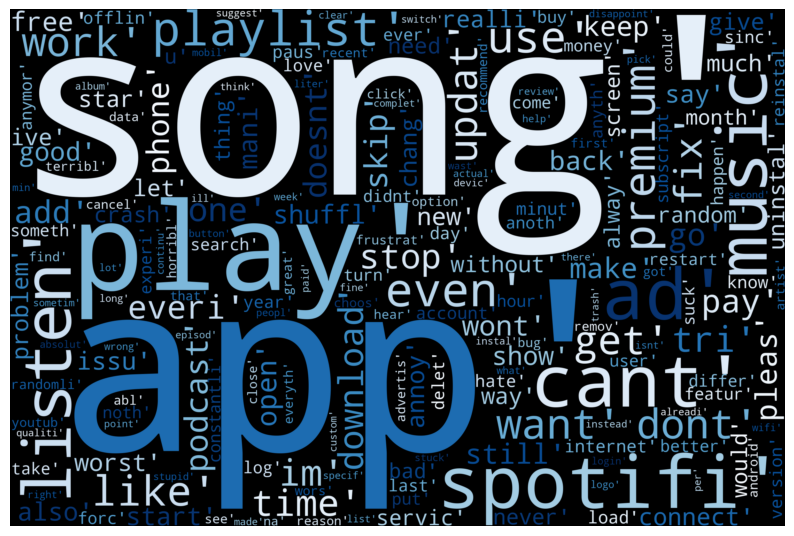

In [217]:
# menampilkan kata
def plot_cloud(word_cloud):
    plt.figure(figsize=(10, 8))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# menggabungkan kata kata (label negatif) menjadi satu kalimat 
all_word = ''.join([str(word) for word in labeled_data.Review[labeled_data.Labels == 0]])

# menyiapkan ukuran figure
wordcloud = WordCloud(
    width=3000, # lebar
    height=2000, # tinggi
    random_state=3, # keacakan posisi kata
    background_color='black', # warna background
    colormap="Blues_r", # colormap pada text
    collocations=False,
    stopwords=STOPWORDS
).generate(all_word)

# menampilkan word cloud
plot_cloud(wordcloud)

berikut kata yang sering muncul pada tweet positif

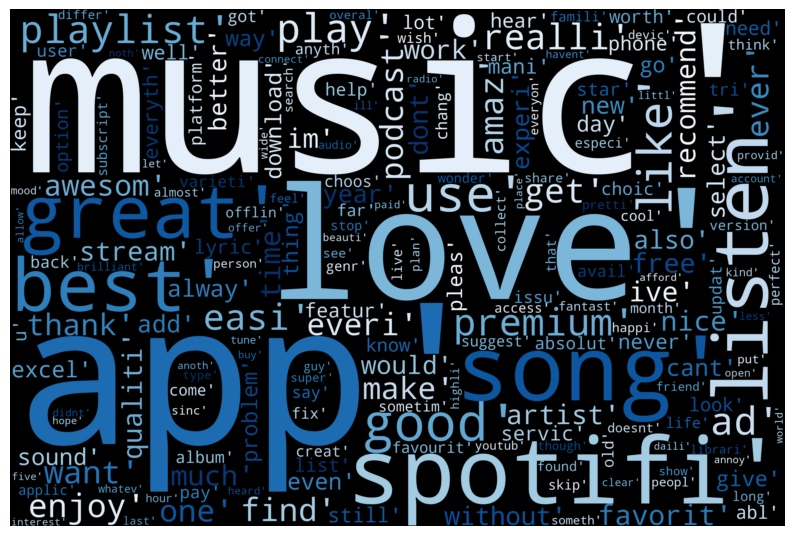

In [218]:
# menampilkan kata
def plot_cloud(word_cloud):
    plt.figure(figsize=(10, 8))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# menggabungkan kata kata (label positif) menjadi satu kalimat 
all_word = ''.join([str(word) for word in labeled_data.Review[labeled_data.Labels == 1]])

# menyiapkan komponen figure
wordcloud = WordCloud(
    width=3000, # lebar
    height=2000, # tinggi
    random_state=3, # keacakan posisi kata
    background_color='black', # warna background
    colormap="Blues_r", # colormap dari text
    collocations=False,
    stopwords=STOPWORDS
).generate(all_word)

# menampilkan word cloud
plot_cloud(wordcloud)

Dapat dilihat kata song ini sangat sering diulangi di tweet positif dan negatif yang artinya kata ini tidak dapat dijadikan atribut karena tidak memiliki pola antara negatif atau positif. Yang akan dihilangkan nanti ketika sudah dihitung bobot

### Frequency of Word

lalu selanjtunya kita hitung kata yang diulang yang akan digunakan sebagai bobot dari data

In [219]:
# kata unik setiap tweet
word_set = []

# mencari kata yang unik
for sent in tokenized:
    for word in sent:
        if word not in word_set:
            word_set.append(word)

# menjadikan set untuk kata unik tersebut
word_set = set(word_set)

# menghitung total dokument
total_document = len(tokenized)

# menjadikan data unik menjadi dictionary
index_dict = {}
i = 0 #untuk iterasi
for word in word_set:
    index_dict[word] = i
    i += 1

In [220]:
# menghitung untuk berapa banyak kata yang unik diulang
def count_dict(senteces): 
    word_count = {}
    for word in word_set:
        word_count[word] = 0
        for sent in tokenized:
            if word in sent:
                word_count[word] += 1
    return word_count

# mengimplementasikan untuk perhitungan semua banyak kata unik yang digunakan
word_count = count_dict(tokenized)
word_count

{'spell': 1,
 'high': 27,
 'truck': 2,
 '𝘀𝗼𝗻𝗴𝘀': 1,
 'iiii': 1,
 'unpleas': 1,
 'thi': 1,
 'half': 22,
 'previou': 17,
 'heartbeat': 2,
 'stranger': 1,
 'alwasi': 1,
 'bare': 8,
 'assist': 4,
 'thumb': 4,
 'frig': 1,
 'listthen': 1,
 'listern': 1,
 'spot': 12,
 'partial': 1,
 'gripe': 1,
 'subscripct': 1,
 'functiona': 1,
 'hate': 98,
 'imo': 1,
 'deletedlong': 1,
 'tought': 1,
 'dusnw': 1,
 'readi': 5,
 'playstat': 4,
 'fc': 1,
 'kakkararjit': 1,
 'travellingit': 1,
 'paragraph': 1,
 'load': 96,
 'test': 4,
 'buyget': 1,
 'cover': 6,
 'divers': 5,
 'bitchinr': 1,
 'fine': 56,
 'memebership': 1,
 'disapear': 1,
 'monthli': 13,
 'bigger': 2,
 'answer': 10,
 'brand': 6,
 'totallyi': 1,
 'tiktok': 1,
 'appropri': 2,
 'fantasticamaz': 1,
 'aapi': 1,
 'crashesfreez': 1,
 'servicebumm': 1,
 'hack': 7,
 'irritatingan': 1,
 'novemb': 1,
 'minut': 97,
 '𝗿𝗲𝗮𝗹𝗹𝘆': 1,
 'untarget': 1,
 'simpler': 2,
 'african': 1,
 'goodi': 2,
 'bozo': 1,
 'depend': 2,
 'tool': 3,
 'hlo': 1,
 'leftist': 1,
 'shirt'

### Term Frequncy

selanjutnya untuk mempersiapkan bobot data kita juga perlu menghitung TF atau Term frequency yaitu menghitung antara banyaknya kata atau term yang muncul pada dokumen tersebut dengan banyaknya kata dari dokumen tersebut.

TF(t, d) = ftid / ntd

In [221]:
# fungsi yang akan menghitung Term Frequency
def termFrequency(document, word):
    # banyaknya term dalam dokumen
    N = len(document)

    # dengan banyaknya term-i yang muncul dalam dokumen
    occurate = document.count(word)

    return occurate/N

### Inverse Document Frequency

Lalu kita juga harus menyiapkan Inverse Document Frequency dilakukan untuk pembobtan kata. IDF ini adalah kita akan menghitung banyaknya dokumen yang didalamnya mengandung suatu term.

IDF(t, D) = log10( N / ftD)

In [222]:
# fungsi yang akan menghitung IDF
def InverseDF(word):
    try:
        # menghitung jumlah data yang  ada
        word_occurance = word_count[word] + 1
    except:
        # jika tidak ditemukan maka akan menjadi 1 untuk menghindari tak terdefinisi
        word_occurance = 1
    return np.log(total_document/word_occurance)

### TF-IDF

Lalu yang terakhir adalah kita tentukan hasil perhitungan pembobot kata dengan menggunakan TF IDF. TF IDF adalah gabungan dari TF dan IDF

TFIDF(t,d, D) = TF(t, d) * IDF(t, D)

In [223]:
# fungsi yang akan menghitungkan tf idf
def tf_idf(sentence):
    # menyiapkan vector yang akan menampung tf idf
    tf_idf_vector = np.zeros((len(word_set), ))

    # menghitung TF IDF untuk seiap kata
    for word in sentence:
        tf = termFrequency(sentence, word)
        idf = InverseDF(word)

        # mengkali TF iDF
        value = tf*idf
        tf_idf_vector[index_dict[word]] = value
    return tf_idf_vector

In [224]:
# melihat banyaknya data yang unik
len(word_set)

4734

In [225]:
# menyiapkan matriks yang akan menampung hasilnya
vectors = []

# menghitung untuk setiap dokumen
for sent in tokenized:
    vec = tf_idf(sent)
    vectors.append(vec)

# menjadikan matriks menjadi dataframe
data = pd.DataFrame(vectors, columns=list(word_set))

# menampilkan data
data

,spell,high,truck,𝘀𝗼𝗻𝗴𝘀,iiii,unpleas,thi,half,previou,heartbeat,...,perfectth,number,sustain,life,perhap,thouand,thru,face,adswherea,asid
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


lalu berdasarkan hasil analisa yang menunjukkan bahwa term yang tak memiliki pola, yang muncul pada tweet negatif maupun positif adalah song maka kita bisa manjadikan acuan song sebagai threshold untuk menghapus term yang tak memiliki pola

kata yang tak memiliki pola adalah kata yang selalu ada pada semua dokumen atau kata yang paling jarang ditemukan dalam suatu dokumen (dapat berkemungkinan typo)

In [226]:
# menunjukkan rata rata tf-idf song
data["song"].mean()

0.04105650538187446

kita dapat menjadikan acuan 0.1 sebagai threshold

In [227]:
# untuk menampung kata yang tak punya pola
uncommon_word = []
index_word = []

# menghitung untuk setiap term
for i, col in enumerate(data.columns):
    # jika rata rata term dibawah threshold maka akan disimpan di uncommon_word yang akan dihapus
    if data[col].mean() < 0.1:
        index_word.append(i)
        uncommon_word.append(col)

# menampilkan kata yang tak memiliki pola 
uncommon_word


['spell',
 'high',
 'truck',
 '𝘀𝗼𝗻𝗴𝘀',
 'iiii',
 'unpleas',
 'thi',
 'half',
 'previou',
 'heartbeat',
 'stranger',
 'alwasi',
 'bare',
 'assist',
 'thumb',
 'frig',
 'listthen',
 'listern',
 'spot',
 'partial',
 'gripe',
 'subscripct',
 'functiona',
 'hate',
 'imo',
 'deletedlong',
 'tought',
 'dusnw',
 'readi',
 'playstat',
 'fc',
 'kakkararjit',
 'travellingit',
 'paragraph',
 'load',
 'test',
 'buyget',
 'cover',
 'divers',
 'bitchinr',
 'fine',
 'memebership',
 'disapear',
 'monthli',
 'bigger',
 'answer',
 'brand',
 'totallyi',
 'tiktok',
 'appropri',
 'fantasticamaz',
 'aapi',
 'crashesfreez',
 'servicebumm',
 'hack',
 'irritatingan',
 'novemb',
 'minut',
 '𝗿𝗲𝗮𝗹𝗹𝘆',
 'untarget',
 'simpler',
 'african',
 'goodi',
 'bozo',
 'depend',
 'tool',
 'hlo',
 'leftist',
 'shirt',
 'jammin',
 'sickest',
 'bestsel',
 'streme',
 'uöò',
 'augh',
 'constantli',
 'regularli',
 'lookup',
 'slight',
 'itpl',
 'audio',
 'typic',
 'stantli',
 'hill',
 'goodby',
 'bandwidth',
 'detent',
 'strip',
 '

Lalu kita menghilangkan term yang tak punya pola tersebut

In [228]:
# menhilangkan term nya
data.drop(columns=uncommon_word, inplace=True)

# Modeling dan Testing

### Pembuatan class

Dalam  tahapan ini akan dilakukan pembuatan class agar lebih memudahkan. Ketika menggunakan class kita dapat melakukan tunnning parameter. Jadi dalam pembuatan class ini kita menyiapkan class yang menyediakan fungsi fungsi dari algoritma KNN atau K Nearest Neighborhood

In [229]:
class KNN:
    # constructor dengan parameter jumlah k dan bobot
    def __init__(self, n_neighbors=3):
        self.n_neighbors = n_neighbors # jumlah k
        self.x = None # data training x
        self.y = None # data training y

    # untuk proses training
    def fit(self, x, y):
        # jika ukuran x berbeda dengan y maka akan error
        if len(x) != len(y):
            raise "size of x is different with size of y"
        
        # hasil training akan disimpan dalam object 
        self.x = np.array(x)
        self.y = np.array(y)

    # digunakan untuk memprediksi satuan 
    def predict(self, x_predict):
            # untuk memastikan kalau myang digunakan itu array numpy 
            x_predict = np.array(x_predict)
            # menghitung semua jarak antara data baru dengan data training
            distance = np.array([np.sum((x_train-x_predict)**2) for x_train in self.x]) 

            # mengambil sebanyak jumlah k jarak yang terpendek dengan dataset yang baru 
            max_distance = np.argsort(distance)[:self.n_neighbors]

            # menentukan labelnya 
            label = [self.y[i] for i in max_distance]

            # mengembalikan label dengan hasil voting terbanyak
            return np.bincount(label).argmax()
    

    # digunakan untuk melihat berapa akurasi model
    def accuracy(self, y_true, y_pred):
        counter = 0 # berapa banyak yang benar

        # looping dari seluruh
        for i in range(len(y_true)):
            # jika benar tambah 1
            if y_true[i] == y_pred[i]:
                counter += 1

        return counter / len(y_true)



### Training

dalam tahapan ini kita akan mentraining data kita dengan menggunakan algoritma KNN

In [230]:
# menyiapkan model
model = KNN(n_neighbors=9)

In [231]:
# mentraining dengan data training
model.fit(data, y_train)

### Testing

dalam tahapan ini kita akan melakukan pengetesan seberapa bagus akurasi yang dapat dilakukan oleh model kita

In [232]:
# fungsinya untuk menerjemahkan bahasa biasa menjadi tf idf yang dipahami mesin
def to_tfidf_inp(input_text):
    # menjadikan variable global
    global total_document, word_count, word_set, new_sentences, vectors, index_dict
    len_x = len(input_text)

    # data cleaning dan preproccess data
    input_text = case_folding(input_text) # case folding
    input_text = word_tokenize(input_text) # tokenize
    input_text = [word for word in input_text if word not in stops] # stopwords
    input_text = [stemmer.stem(token) for token in input_text] # stemming

    # pembobotan kata
    new_sentences = list(tokenized).copy() # menjadikan list
    new_sentences.append(input_text) # menambahkan datatest pada ist tfidf
    total_document = len(new_sentences) # menghitung banyaknya dokumen
    word_count = count_dict(new_sentences) 

    # memperbarui kata unik
    word_set = []

    for sent in new_sentences:
        for word in sent:
            if word not in word_set:
                word_set.append(word)

    word_set = set(word_set)

    index_dict = {}
    i = 0
    for word in word_set:
        index_dict[word] = i
        i += 1

    # melakukan perhitungan tfidf
    vectors = []

    for sent in new_sentences:
        vec = tf_idf(sent)
        vectors.append(vec)

    # menentukan data train dan data test
    train = np.array(vectors[:-1])
    test = np.array([vectors[-1]])

    # mengembalikan datatrain dan data test
    return train, test


In [233]:
xtrain, xtest = to_tfidf_inp(X_test.iloc[0])
model.fit(xtrain, y_train)

predicted_class = model.predict(xtest)
predicted_class, y_test.iloc[0]

(0, 0)

melakukan pengetesan pada salah satu kalimat / tweet

In [234]:
# menyimpan hasil prediksi
test_predict = []
for i, x in enumerate(X_test.iloc[:30]):
    print("iteration -", (i+1), "/", len(X_test.iloc[:30]))

    # menyimpan datatrain dan datatest yang sudah di convert tf idf
    xtrain, _input = to_tfidf_inp(x)

    # melakukan training
    model.fit(xtrain, y_train)

    # menambahkan hasil prediksi
    test_predict.append(model.predict(_input))

test_predict

iteration - 1 / 30
iteration - 2 / 30
iteration - 3 / 30
iteration - 4 / 30
iteration - 5 / 30
iteration - 6 / 30
iteration - 7 / 30
iteration - 8 / 30
iteration - 9 / 30
iteration - 10 / 30
iteration - 11 / 30
iteration - 12 / 30


KeyboardInterrupt: 

In [ ]:
# menghitung hasil akurasi
model.accuracy(y_test.iloc[:30].to_numpy(), test_predict)

0.8666666666666667

k = 5 => 0.8666666666666667 %
k = 3 => 0.8333333333333334 %
k = 7 => 0.8666666666666667 %
k = 9 => 0.8666666666666667 %

### Conclusion